In [1]:
import os
import torchaudio
import nemo.collections.asr as nemo_asr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jiwer import wer, mer, wil
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

[NeMo W 2024-11-13 19:40:28 nemo_logging:393] Could not import NeMo NLP collection which is required for speech translation model.


In [2]:
asr_model = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="stt_en_jasper10x5dr")

[NeMo I 2024-11-13 19:40:28 nemo_logging:381] Found existing object C:\Users\51man\.cache\torch\NeMo\NeMo_1.21.0\stt_en_jasper10x5dr\856ae08d5c4bd78b5e27f696e96f7aab\stt_en_jasper10x5dr.nemo.
[NeMo I 2024-11-13 19:40:28 nemo_logging:381] Re-using file from: C:\Users\51man\.cache\torch\NeMo\NeMo_1.21.0\stt_en_jasper10x5dr\856ae08d5c4bd78b5e27f696e96f7aab\stt_en_jasper10x5dr.nemo
[NeMo I 2024-11-13 19:40:28 nemo_logging:381] Instantiating model from pre-trained checkpoint


[NeMo W 2024-11-13 19:40:47 nemo_logging:393] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data2/voices/train_1k.json
    sample_rate: 16000
    labels:
    - ' '
    - a
    - b
    - c
    - d
    - e
    - f
    - g
    - h
    - i
    - j
    - k
    - l
    - m
    - 'n'
    - o
    - p
    - q
    - r
    - s
    - t
    - u
    - v
    - w
    - x
    - 'y'
    - z
    - ''''
    batch_size: 32
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    
[NeMo W 2024-11-13 19:40:47 nemo_logging:393] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath:

[NeMo I 2024-11-13 19:40:47 nemo_logging:381] PADDING: 16


[NeMo W 2024-11-13 19:40:58 nemo_logging:393] d:\Anaconda\Lib\site-packages\nemo\core\connectors\save_restore_connector.py:568: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 

[NeMo I 2024-11-13 19:41:06 nemo_logging:381] Model EncDecCTCModel was successfully restored from C:\Users\51man\.cache\torch\NeMo\NeMo_1.21.0\stt_en_jasper10x5dr\856ae08d5c4bd78b5e27f696e96f7aab\stt_en_jasper10x5dr.nemo.


In [3]:

audio_file = r"D:\voice-based-pronunciation-prediction\SA1.WAV"
waveform, sample_rate = torchaudio.load(audio_file)
if sample_rate != 16000:
    waveform = torchaudio.transforms.Resample(sample_rate, 16000)(waveform)

temp_audio_path = "temp.wav"
torchaudio.save(temp_audio_path, waveform, 16000)

predicted_text = asr_model.transcribe([temp_audio_path])[0]
print("Jasper Predicted Text:", predicted_text)

ground_truth_text = "She had your dark suit in greasy wash water all year"



Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2024-11-13 19:41:07 nemo_logging:393] d:\Anaconda\Lib\site-packages\nemo\collections\asr\parts\preprocessing\features.py:417: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
      with torch.cuda.amp.autocast(enabled=False):
    


Jasper Predicted Text: she had your duck suit and greasy washwater all year


In [4]:
error_rate = wer(ground_truth_text.lower(), predicted_text.lower())
match_error_rate = mer(ground_truth_text.lower(), predicted_text.lower())
wil_rate = wil(ground_truth_text.lower(), predicted_text.lower())
print("Word Error Rate:", error_rate)
print("Match Error Rate:", match_error_rate)
print("Word Information Lost Rate:", wil_rate)



Word Error Rate: 0.36363636363636365
Match Error Rate: 0.36363636363636365
Word Information Lost Rate: 0.5545454545454546


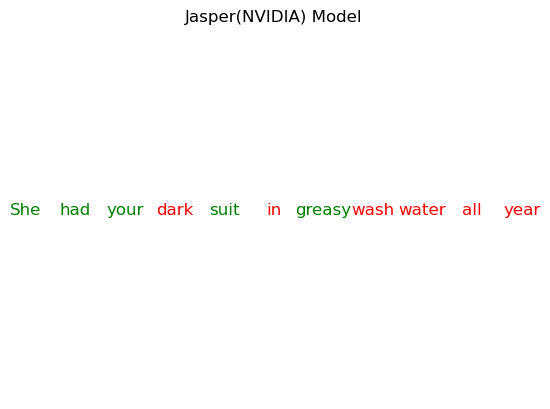

In [5]:
def visualize_pronunciation(ground_truth, prediction):
    ground_truth_words = ground_truth.split()
    predicted_words = prediction.split()
    
    fig, ax = plt.subplots()
    for idx, word in enumerate(ground_truth_words):
        color = 'green' if idx < len(predicted_words) and word.lower() == predicted_words[idx].lower() else 'red'
        ax.text(idx * 0.1, 0.5, word, color=color, fontsize=12, ha='center')
    ax.axis('off')
    ax.set_title('Jasper(NVIDIA) Model')
    plt.show()

visualize_pronunciation(ground_truth_text, predicted_text)


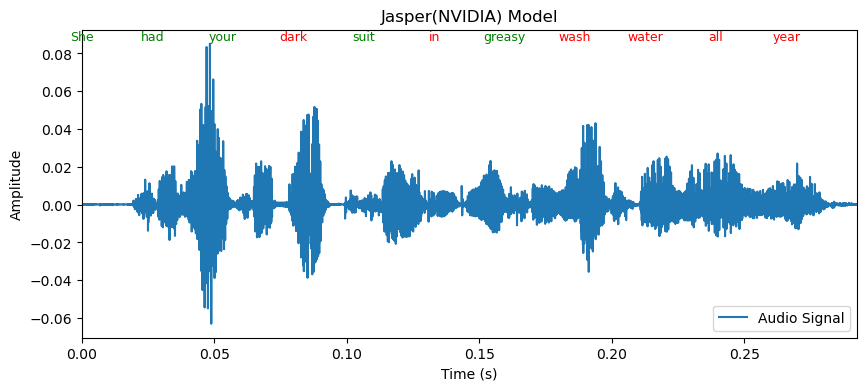

In [6]:
def visualize_audio_with_text_overlay(waveform, ground_truth, prediction, sample_rate=16000, downsample_factor=10):
    waveform = waveform[0, ::downsample_factor]  
    ground_truth_words = ground_truth.split()
    predicted_words = prediction.split()

    total_time = waveform.size(0) / sample_rate
    word_times = np.linspace(0, total_time, len(ground_truth_words) + 1)

    fig, ax = plt.subplots(figsize=(10, 4)) 
    ax.plot(np.linspace(0, total_time, waveform.size(0)), waveform.numpy(), label="Audio Signal")
    
    for idx, word in enumerate(ground_truth_words):
        color = 'green' if idx < len(predicted_words) and word.lower() == predicted_words[idx].lower() else 'red'
        ax.text(word_times[idx], waveform.max(), word, color=color, fontsize=9, ha='center', va='bottom')
    
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.set_title('Jasper(NVIDIA) Model')
    ax.set_xlim(0, total_time)  
    plt.legend()
    plt.show()

visualize_audio_with_text_overlay(waveform, ground_truth_text, predicted_text)


In [7]:
def get_labels(ground_truth, prediction):
    ground_truth_words = ground_truth.split()
    predicted_words = prediction.split()
    labels = [1 if gt.lower() == pd.lower() else 0 for gt, pd in zip(ground_truth_words, predicted_words)]
    return labels

labels = get_labels(ground_truth_text, predicted_text)

accuracy = accuracy_score([1]*len(labels), labels)
precision = precision_score([1]*len(labels), labels)
recall = recall_score([1]*len(labels), labels)
f1 = f1_score([1]*len(labels), labels)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")



Accuracy: 0.50
Precision: 1.00
Recall: 0.50
F1 Score: 0.67


[NeMo W 2024-11-13 19:41:11 nemo_logging:393] C:\Users\51man\AppData\Local\Temp\ipykernel_22312\1419713132.py:5: FutureWarning: 
    
    Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.
    
      sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="Blues_d")
    


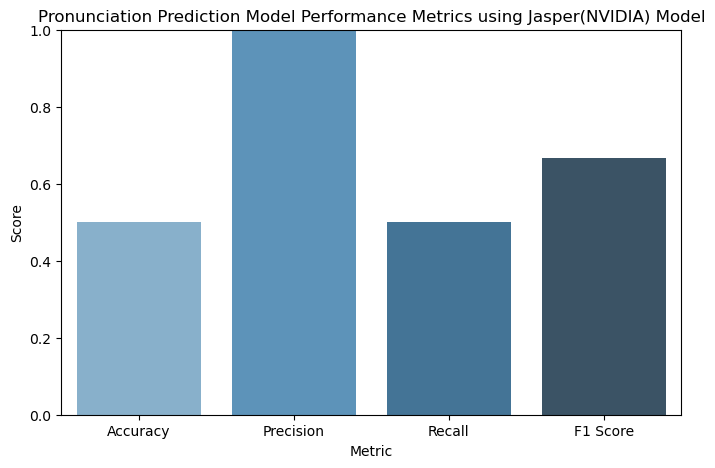

In [8]:

def plot_performance_metrics(accuracy, precision, recall, f1):
    metrics = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="Blues_d")
    plt.ylim(0, 1)
    plt.title("Pronunciation Prediction Model Performance Metrics using Jasper(NVIDIA) Model")
    plt.ylabel("Score")
    plt.xlabel("Metric")
    plt.show()
plot_performance_metrics(accuracy, precision, recall, f1)
